# Modelling European Swaptions using Short Rate Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from math import prod
import scipy.optimize as scop
import itertools

## Initialize Variables 

In [48]:
sig = 0.3       #Initial Volatility assumption
d_steps = 20    #Discritizations steps 
N =100000      #Simulations
Max_Time = 30   #Maximum time in this model

## Black Derman Toy Model Calibration and Bond Valuation

### Generate Random Variables and Bond Data

In [33]:
#generate Normal Random variables to reduce simulation error - Common random variable method
def generateRandomVars(T):
    #z1 : array [time][simulation]
    z1 = [np.random.normal(0,1,N) for i in range(int(T*d_steps))]
    return z1

def theta1(alpha, beta, t):
    return (alpha*t + beta * (t**2)/2)
 
x= generateRandomVars(Max_Time)
#Calibration using 10 Bonds : Bond prices from bootstrapping results 
#List of  CB Prices (Bond Price, tenure)
Bond_prices = [(0.969777925008976,1),(0.936177883024023,2),(0.906459602841119,3),(0.880358920389114,4),(0.854468123403658,5),(0.829964430055826,6),(0.805987832269141,7),(0.784004238503967,8),(0.762790697492938,9),(0.742319437015706,10)]
#Bond Prices from 11yrs to 30 yrs
#,(0.719216096343259,11),(0.696413734865548,12),(0.673920527224596,13),(0.651744111645529,14),(0.62989159604486,15),(0.608369564739779,16),(0.587184085729413,17),(0.566340718518812,18),(0.545844522456156,19),(0.525700065553639,20),(0.512556924351337,21),(0.499988915875595,22),(0.487972204701656,23),(0.476484053280391,24),(0.4655027693762,25),(0.455007656160627,26),(0.444978964822177,27),(0.435397849560348,28),(0.426246324839216,29),(0.417507224782538,30)]

### Define Function for Bond Valuation and Calibration

In [9]:

def CalibrateModel(params, theta, Bt,z ):
    sig, alpha , beta, ro = params
    error_sum = 0
    for bp,t in Bt:
        n_dt = int(t*d_steps)
        dt = t /n_dt
        rt = [ro]*n_dt
        disc_fac = [1]*n_dt
        temp_ZCB_price = [1]*N
        for i in range(1,n_dt):
            # Use Geometric Brownian Motion SDE for the rate
            rt[i] = -rt[i-1] * np.exp((theta(alpha, beta, dt) - (sig**2)/2)*(dt) + sig * (dt)**0.5 * z[i-1])    #Simulate short rate for a very short time dt 
            disc_fac[i] = np.exp(rt[i]*-dt)                                                                     # Discount factor for the discretized time 
        
        temp = np.array(disc_fac[1:])                                                                           # Convert into matrix
        temp = temp.T                                                                                           # Take Transpose of the matrix
         
        temp_ZCB_price = [prod(temp[i]) for i in range(N)]                                                      # Take average of Bond Price from different simulations
        # print(np.mean(temp_ZCB_price),bp)
        error_sum = error_sum + (np.mean(temp_ZCB_price)-bp)**2                                                 # Error is the difference between calculated and actual price of ZCB

    
    return error_sum**0.5


def GetBondPrice(params, theta, tenure ,z):
    sig, alpha , beta, ro = params
    # ro = 0.0035                                                                                               # Current overnight Fed Rate
    # sig = 0.00390879                                                                                            # Variance of overnight Fed Rate
    n_dt = int(tenure*d_steps)
    dt = tenure /n_dt
    rt = [ro]*n_dt
    disc_fac = [1]*n_dt
    temp_ZCB_price = [1]*N
    for i in range(1,n_dt):
        #Simulate short rate and multiply by current discount factor
        rt[i] = -rt[i-1] * np.exp((theta(alpha, beta, dt) - (sig**2)/2)*(dt) + sig * (dt)**0.5 * z[i-1])    #Simulate short rate for a very short time dt 
        disc_fac[i] = np.exp(rt[i]*-dt)                                                                     # Discount factor for the discretized time 
    #multiply into temp discount variable
    temp = np.array(disc_fac[1:])
    temp = temp.T
    temp_ZCB_price = [prod(temp[i]) for i in range(N)]

    #take average of discount factor 
    return np.mean(temp_ZCB_price)


### Calibrate Model

In [34]:
x0 =  [0.39,0.2,0.5,0.0035] #initial guess
res1 = scop.minimize(CalibrateModel,x0,args=(theta1,Bond_prices,x))

### Bond Valuation

In [43]:
#Valuation of Bond
tenure = 7
rnorm= generateRandomVars(tenure)
params = res1.x
rex = GetBondPrice(params,theta=theta1,tenure = tenure,z = rnorm)
print(['Calculated Value:' ,rex ])
print(['Actual Value:' ,Bond_prices[tenure-1][0]])

['Calculated Value:', 0.8323354431657881]
['Actual Value:', 0.805987832269141]


In [36]:
params

array([ 0.46633875,  0.30985707,  0.50549342, -1.03378023])

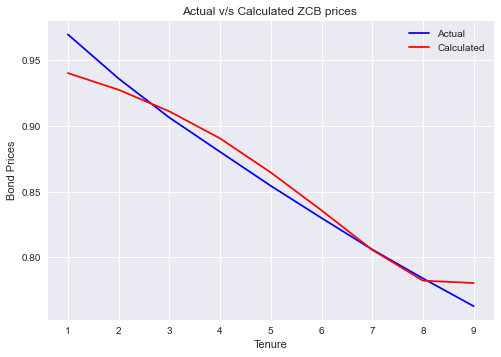

In [69]:
#Bond Valuation results and comparison
act_bond_prices = []
cal_bond_price = []
params = res1.x
for bp,i in Bond_prices:
    act_bond_prices.append(bp)
    rnorm= generateRandomVars(i)
    cal_bond_price.append(GetBondPrice(params,theta=theta1,tenure = i,z = rnorm))

plt.style.use('seaborn')
# plt.figure(figsize=(12,8))
plt.plot(range(1,10),act_bond_prices[:9],color = 'Blue')
plt.plot(range(1,10),cal_bond_price[:9],color = 'red')
plt.ylabel('Bond Prices')
plt.xlabel('Tenure')
plt.title('Actual v/s Calculated ZCB prices ')
plt.legend(["Actual","Calculated"])
plt.show()


## Swaption Valuation

In [51]:
# Terms of the Swaptions
Option_term = 2                 # Years for which option is valid for 
Swap_term = 4                   # Total term of the swap (swap starts after option is exercised)
Swap_rate = 0.04                # Swap rate for Fixed leg
Notional = 100000               # Notional underlying the swap    
random_variables = generateRandomVars(10)
# params = res1.x                 # Calibrated model paramters
params = [ 0.38158359,  0.26257618,  0.50312882, -1.10274937]
payment_freq = 0.5 

In [40]:
def getSwaptionValue(op_term, sw_term , sw_rate, Ntn , params, z, theta):
    sig, alpha , beta, ro = params                                                                          # Unpack calibrated parameters 
    n_dt = int((sw_term+op_term)*d_steps)                                                                   # No of discrete time steps with the given terms
    payment_terms = np.arange(Option_term,Swap_term+0.5,payment_freq)*d_steps                               # Payment times for the swaps
    dt = sw_term /n_dt                                                                                      # length of each discrete time
    rt = [ro]*n_dt                                                                                          # initialize short rate list
    disc_fac = [1]*n_dt                                                                                     # initialize discount factor list
    temp_disc_rate = []                                                                                     # initialize temperory varriable
    
    #Initilize important lists for bond prices used in swaption pricing formula
    P_0_To = []
    P_0_Tn = []
    Sum_P_To_Ti = [1]*N

    # Loop over all discrete times 

    for i in range(1,n_dt):
        #Simulate short rate and Calculate discount facotrs/ZCB prices
        rt[i] = -rt[i-1] * np.exp((theta(alpha, beta, dt) - (sig**2)/2)*(dt) + sig * (dt)**0.5 * z[i-1])    #Simulate short rate for a very short time dt 
        disc_fac[i] = np.exp(rt[i]*-dt)                                                                     # Discount factor for the discretized time 

        # When we reach term of option, save the bond price to be used later
        if i == (op_term *d_steps):
            # ZCB Bond price of tenure = op_term To
            temp = np.array(disc_fac[1:i],dtype=object)
            temp = temp.T                                                                                   # Convert the [time X simulation] array to [Simulation X Time]
            P_0_To = [prod(temp[j]) for j in range(N)]                                                      # Take product of discount factors in each simulation

        # When we reach term of swap payment/end, save the bond price to be used later
        if i in payment_terms:
            # add the discount facotrs for each payment term 
            temp = np.array(disc_fac[1:i],dtype=object)
            temp = temp.T                                                                                   # Convert the [time X simulation] array to [Simulation X Time]
            temp_disc_rate = [prod(temp[j]) for j in range(N)]                                              # Take product of discount factors in each simulation
            Sum_P_To_Ti = [Sum_P_To_Ti[j] + temp_disc_rate[j] for j in range(N)]                            # Sum the products of all payments  
            if i == payment_terms[-1]:
                P_0_Tn = temp_disc_rate
    
    payoff = [max(Ntn*(1 - (P_0_Tn[i]/P_0_To[i]) - (sw_rate * payment_freq * Sum_P_To_Ti[i])),0) for i in range(N)]     # swaption Formula 
    Swaption_price = np.mean([payoff[i]*P_0_To[i] for i in range(N)])                                                   # Take average of payoff and discount back to time 0

    #take average of discount factor 
    return Swaption_price


In [49]:
t = getSwaptionValue(Option_term,Swap_term,Swap_rate,Notional,params,random_variables,theta1)
print("Swaption Price: $",t)

Swaption Price: $ 89.15268567708245


In [57]:
#Swaption price for different swap rates
value = []
for swap_r in np.arange(0.01,0.05,0.001):
    value.append(getSwaptionValue(Option_term,Swap_term,swap_r,Notional,params,random_variables,theta1))
value

[409.0065380563941,
 363.8761837991769,
 324.1722846147858,
 289.30512602838735,
 258.6367188391845,
 231.63988298706118,
 207.82550886309986,
 186.79773479598435,
 168.10969946100698,
 151.5157593291856,
 136.7143073242795,
 123.59371675467995,
 111.81106507886311,
 101.2505189490387,
 91.81738429384811,
 83.33768589242177,
 75.74932911213433,
 68.908257490442,
 62.74500423870679,
 57.2182252861795,
 52.215750213999634,
 47.680629775706755,
 43.577406937684266,
 39.82752093592842,
 36.41873926074565,
 33.31276170932679,
 30.50887462543112,
 27.94798673983307,
 25.58640655679794,
 23.429462254756327,
 21.469372389443354,
 19.697132517446686,
 18.07504270771951,
 16.5872282396092,
 15.225657784635795,
 13.976198227075038,
 12.843308851095223,
 11.82700271720508,
 10.906522978345624,
 10.065130598722918]

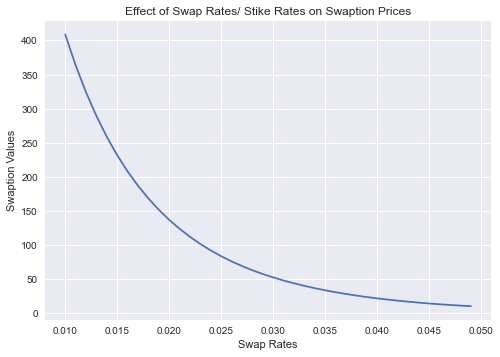

In [60]:
plt.style.use('seaborn')
# plt.figure(figsize=(12,8))
plt.plot(np.arange(0.01,0.05,0.001),value)
plt.ylabel('Swaption Values')
plt.xlabel('Swap Rates')
plt.title('Effect of Swap Rates/ Stike Rates on Swaption Prices')
plt.show()